In [1]:
import sys

from pathlib import Path

from math import pi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

In [2]:
%matplotlib inline
plt.style.use('fast')
plt.rcParams['figure.figsize'] = [11, 9]
plt.rcParams['font.size'] = 14
plt.style.use('seaborn-dark')

In [3]:
# Propylene Glycol 50%
brine_fluid_str = "INCOMP::MPG[0.5]"

In [4]:
def load_init_data(file_name):
    
    # load data
    df = pd.read_csv(file_name, index_col=["Time [min]"])
    
    # convert gal/min to m3/s
    # http://www.kylesconverter.com/flow/cubic-meters-per-second-to-gallons-(us-fluid)-per-minute
    m3sec_to_galmin = 15850.323144
    
    vdot_cols = {"V_ice [gal/min]": "V_ice [m3/s]",
                 "V_load [gal/min]": "V_load [m3/s]",
                 "V_cond [gal/min]": "V_cond [m3/s]"
                }
    
    for k, v in vdot_cols.items():
        df[k] = df[k] / m3sec_to_galmin
    
    # rename vdot cols
    df.rename(columns=vdot_cols, inplace=True)
    
    # compute brine mass flow rate
    df["mdot_ice [kg/s]"] = np.nan
    for idx in range(len(df["V_ice [m3/s]"])):
        inlet_temp = df["T_ice_in [C]"].iloc[idx]
        density = PropsSI("D", "T", inlet_temp + 273.15, "P", 140000, brine_fluid_str)
        df["mdot_ice [kg/s]"].iloc[idx] = density * df["V_ice [m3/s]"].iloc[idx]
    
    # compute cooling rate
    df["Q_ice [kW]"] = np.nan
    for idx in range(len(df["V_ice [m3/s]"])):
        inlet_temp = df["T_ice_in [C]"].iloc[idx]
        outlet_temp = df["T_ice_out [C]"].iloc[idx]
        cp = PropsSI("C", "T", inlet_temp + 273.15, "P", 140000, brine_fluid_str) / 1000.0
        mdot = df["mdot_ice [kg/s]"].iloc[idx]
        df["Q_ice [kW]"].iloc[idx] = mdot * cp * (inlet_temp - outlet_temp)

    # chiller power W to kW
    df["Pwr_chiller [W]"] /= 1000.0
    df.rename({"Pwr_chiller [W]": "Pwr_chiller [kW]"}, inplace=True, axis=1)
        
    # return early if we can't compute COP
    if df["T_evap_in [C]"].isnull().all():
        return df
    
    # compute chiller cop
    df["COP"] = np.nan
    df["Q_evap [kW]"] = np.nan
    for idx in range(len(df["V_ice [m3/s]"])):
        evap_inlet_temp = df["T_evap_in [C]"].iloc[idx]
        evap_outlet_temp = df["T_evap_out [C]"].iloc[idx]
        ave_temp = (evap_inlet_temp + evap_outlet_temp) / 2.0
        cp = PropsSI("C", "T", ave_temp + 273.15, "P", 140000, brine_fluid_str) / 1000.0
        mdot = df["mdot_ice [kg/s]"].iloc[idx]
        q_evap = mdot * cp * (evap_outlet_temp - evap_inlet_temp)
        df["Q_evap [kW]"].iloc[idx] = q_evap
        pwr = df["Pwr_chiller [kW]"].iloc[idx]
        df["COP"].iloc[idx] = abs(q_evap / pwr)
        
    return df

In [5]:
df_charge = load_init_data("charge_1min_resample.csv")

In [6]:
def plot_tin_tout(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    col = "T_ice_in [C]"
    ax1.plot(df[col], label=col)
    
    col = "T_ice_out [C]"
    ax1.plot(df[col], label=col)
    ax1.grid()
    ax1.legend()
    
    col = "mdot_ice [kg/s]"
    ax2.plot(df[col], label=col)
    ax2.grid()
    ax2.legend()
    
    col = "Q_ice [kW]"
    ax3.plot(df[col], label=col)
    ax3.grid()
    ax3.legend()
    
    plt.show()

## Charging

In [7]:
# plot_tin_tout(df_charge)

## Discharging

In [8]:
df_4 = load_init_data("discharge_4_1min_resample.csv")

In [9]:
# plot_tin_tout(df_4)

In [10]:
df_6 = load_init_data("discharge_6_1min_resample.csv")

In [11]:
# plot_tin_tout(df_6)

In [12]:
df_8 = load_init_data("discharge_8_1min_resample.csv")

In [13]:
# plot_tin_tout(df_8)

In [14]:
from thermal_tank.simple_ice_tank import IceTank

In [15]:
def plot_exp(df, data, plot_name, title):
       
    inlet_temps = df["T_ice_in [C]"]
    mass_flow_rates = df["mdot_ice [kg/s]"].values

    tank = IceTank(data)

    outlet_temps = []
    ice_mass = []

    time = 0
    timestep = 60
    
    for idx, t in enumerate(inlet_temps):
        mdot = mass_flow_rates[idx]    
        t_env = 20
        tank.calculate(t, mdot, t_env, time, timestep)
        outlet_temps.append(tank.outlet_fluid_temp)
        ice_mass.append(tank.ice_mass)
        time += timestep
            
    # create figure with four subplots
    fig, (ax1, ax2, ax3, ax4)= plt.subplots(4,1)
    
    fig.suptitle(f"{title}", fontsize=20)
    
    # populate subplot 1
    ax1.plot(inlet_temps, label=r"$T_{in}$ Exp")
    ax1.plot(df["T_ice_out [C]"].values, label=r"$T_{out}$ Exp")
    ax1.plot(outlet_temps, label=r"$T_{out}$ Model", linestyle="--")
    ax1.set_ylabel("Temp [C]")
    ax1.legend(ncol=3)
    ax1.grid()
    
    # populate subplot 2
    ax4.plot(ice_mass, label="Model", linestyle="--")
    ax4.set_xlabel("Time [min]")
    ax4.set_ylabel("Ice Mass [kg]")
    ax4.legend()
    ax4.grid()
    
    # populate subplot 3
    q_exp = []
    q_model = []
    
    for idx, t in enumerate(inlet_temps):
        # exp q
        t_out_exp = df["T_ice_out [C]"].iloc[idx]
        t_mft_exp = (t + t_out_exp) / 2.0
        cp_exp = PropsSI('C', 'T', 273.15 + t_mft_exp, 'P', 140000, "INCOMP::MPG[0.3]")
        m_dot = mass_flow_rates[idx]
        q_exp_watts = m_dot * cp_exp * (t - t_out_exp)
        q_exp_kwh = q_exp_watts * (1/1000) * (60/3600)
        q_exp.append(q_exp_kwh)
        
        # model q
        t_out_model = outlet_temps[idx]
        t_mft_model = (t + t_out_model) / 2.0
        cp_model = PropsSI('C', 'T', 273.15 + t_mft_model, 'P', 140000, "INCOMP::MPG[0.3]")
        q_model_watts = m_dot * cp_model * (t - t_out_model)
        q_model_kwh = q_model_watts * (1/1000) * (60/3600)
        q_model.append(q_model_kwh)
    
    q_exp = np.array(q_exp)
    cumsum_q_exp = np.cumsum(q_exp)
    
    q_model = np.array(q_model)
    cumsum_q_model = np.cumsum(q_model)
    
    ax2.plot(cumsum_q_exp, label="Exp")
    ax2.plot(cumsum_q_model, label="Model", linestyle="--") 
    ax2.set_ylabel("Sum HT [kWh]")
    ax2.legend(ncol=2)
    ax2.grid()
    
    # populate subplot 4
    q_error = (cumsum_q_exp - cumsum_q_model) / cumsum_q_exp * 100.0
    ax3.plot(q_error)
    ax3.set_yticks(range(-20, 30, 10))
    ax3.set_ylim([-20, 20])
    ax3.set_ylabel("HT Error [%]")
    ax3.grid()
    
#     plot_path = Path("/Users/mmitchel/Projects/EnergyPlus/dev/IPYNotebooks/2021_04-Calmac_Tank") / f"{plot_name}.png"
#     plt.savefig(plot_path, bbox_inches="tight")
    plt.show()
    
    outlet_temp_errors = np.abs((np.array(outlet_temps) - df['T_ice_out [C]'])/ df['T_ice_out [C]'])
    cumsum_q_errors = np.abs((cumsum_q_exp - cumsum_q_model) / cumsum_q_exp)
    return outlet_temp_errors, cumsum_q_errors

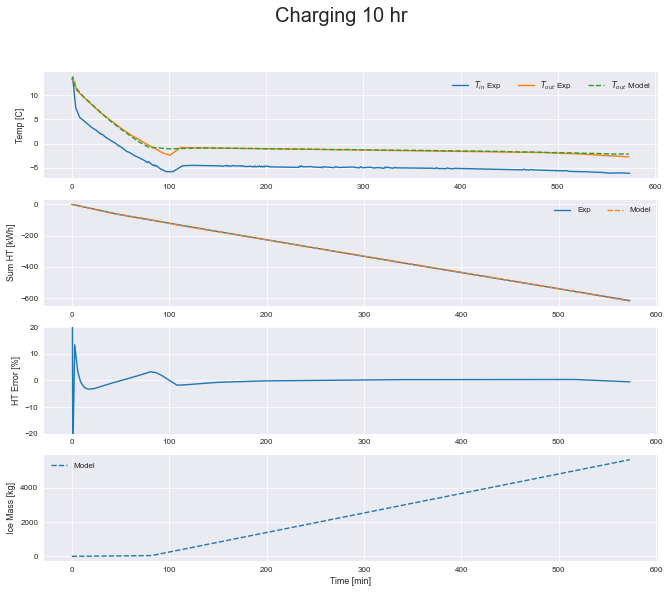

75.48661442103867 5.385265001440719


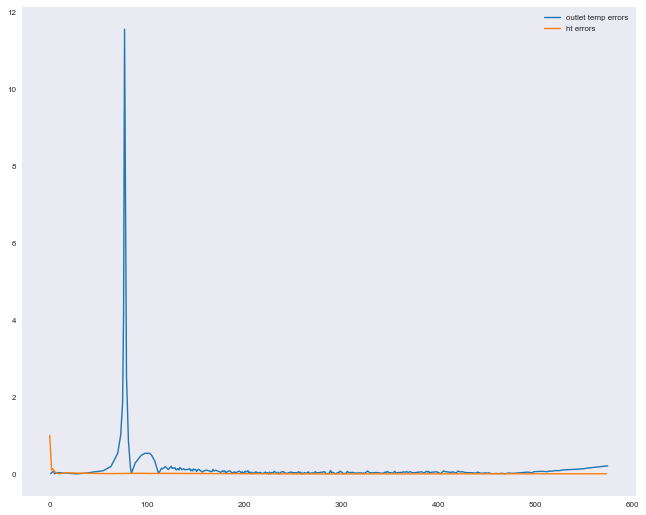

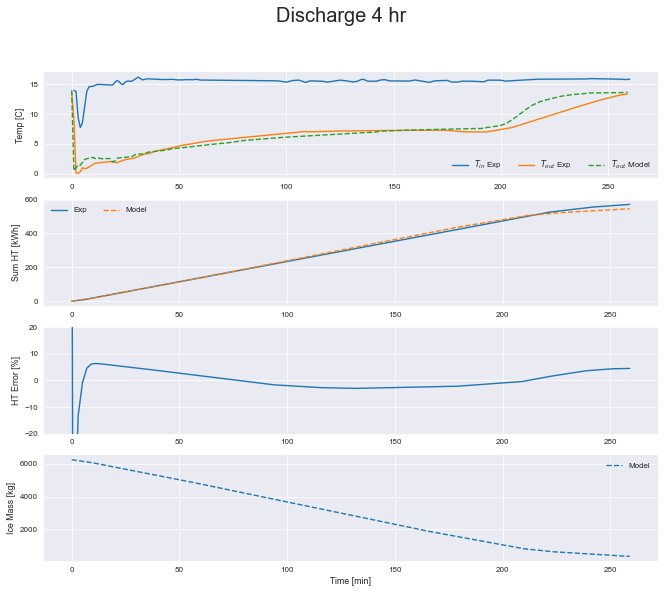

82.4776360283974 10.112780380216392


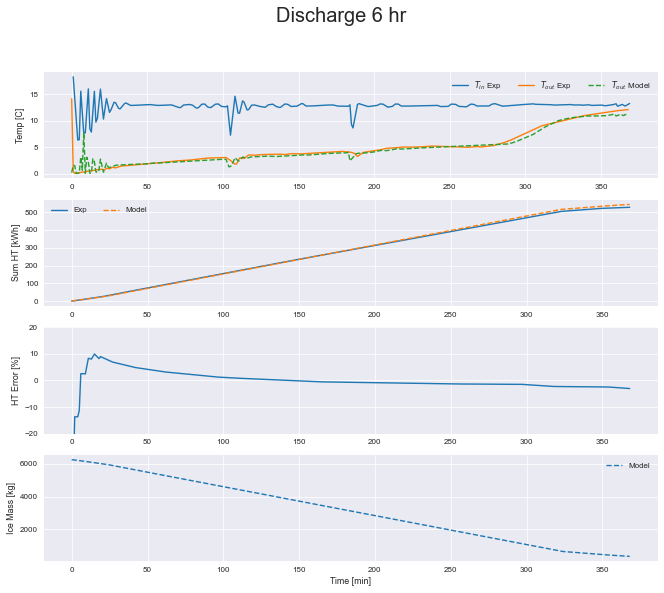

125.58525818113768 11.548725300872183


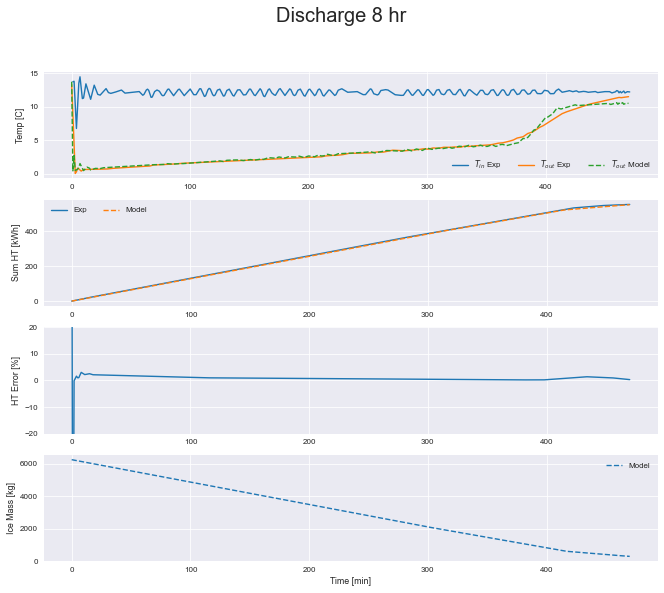

71.37155217461633 6.938810079988798
[75.48661442103867, 82.4776360283974, 125.58525818113768, 71.37155217461633] 354.9210608051901
[5.385265001440719, 10.112780380216392, 11.548725300872183, 6.938810079988798] 33.98558076251809


In [17]:
# Original
# [74.8535103506447, 82.50117157617089, 125.81838074778065, 72.47446240531208] 355.64752507990835
# [5.29527140064141, 9.962219973531237, 11.436736152504293, 7.2702369770494055] 33.96446450372635
original_total_outlet_temp_errors = []
original_total_ht_errors = []
data = {
        "tank_diameter": 89 * 0.0254,  # 89 inches
        "tank_height": 101 * 0.0254,  # 101 inches
        "fluid_volume": 1655 * 0.00378541,  # 1655 gal
        "r_value_lid": 24 / 5.67826,  # R-24
        "r_value_base": 9 / 5.67826,  # R-9
        "r_value_wall": 9 / 5.67826,  # R-9
        "initial_temperature": df_charge["T_ice_in [C]"].iloc[0],
        }
outlet_temp_errors, ht_errors = plot_exp(df_charge, data, "charge", "Charging 10 hr")
plt.plot(outlet_temp_errors, label="outlet temp errors")
plt.plot(ht_errors, label="ht errors")
plt.legend()
print(sum(outlet_temp_errors), sum(ht_errors))
original_total_outlet_temp_errors.append(sum(outlet_temp_errors))
original_total_ht_errors.append(sum(ht_errors))

data = {
        "tank_diameter": 89 * 0.0254,  # 89 inches
        "tank_height": 101 * 0.0254,  # 101 inches
        "fluid_volume": 1655 * 0.00378541,  # 1655 gal
        "r_value_lid": 24 / 5.67826,  # R-24
        "r_value_base": 9 / 5.67826,  # R-9
        "r_value_wall": 9 / 5.67826,  # R-9
        "latent_state_of_charge": 1.0,
        }

outlet_temp_errors, ht_errors = plot_exp(df_4, data, "discharge_4", "Discharge 4 hr")
original_total_outlet_temp_errors.append(sum(outlet_temp_errors))
original_total_ht_errors.append(sum(ht_errors))
print(sum(outlet_temp_errors), sum(ht_errors))

outlet_temp_errors, ht_errors = plot_exp(df_6, data, "discharge_6", "Discharge 6 hr")
original_total_outlet_temp_errors.append(sum(outlet_temp_errors))
original_total_ht_errors.append(sum(ht_errors))
print(sum(outlet_temp_errors), sum(ht_errors))

outlet_temp_errors, ht_errors = plot_exp(df_8, data, "discharge_8", "Discharge 8 hr")
original_total_outlet_temp_errors.append(sum(outlet_temp_errors))
original_total_ht_errors.append(sum(ht_errors))
print(sum(outlet_temp_errors), sum(ht_errors))

print(original_total_outlet_temp_errors, sum(original_total_outlet_temp_errors))
print(original_total_ht_errors, sum(original_total_ht_errors))

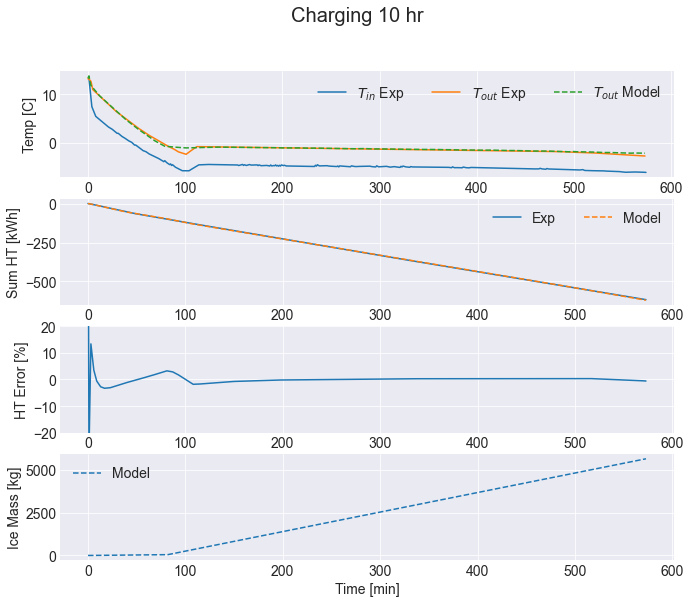

75.48590646786229 5.385395333867815


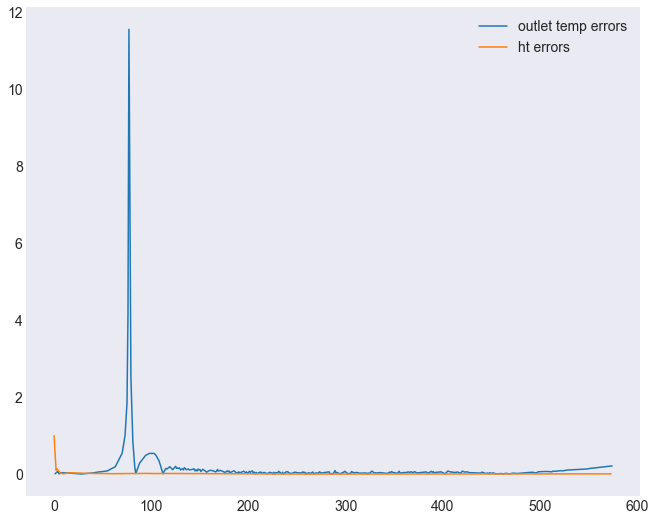

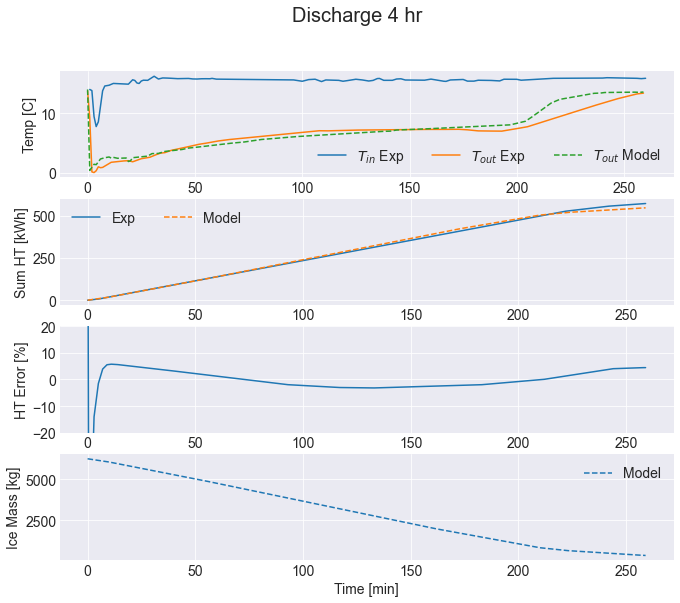

80.06362641598032 10.029461002998323


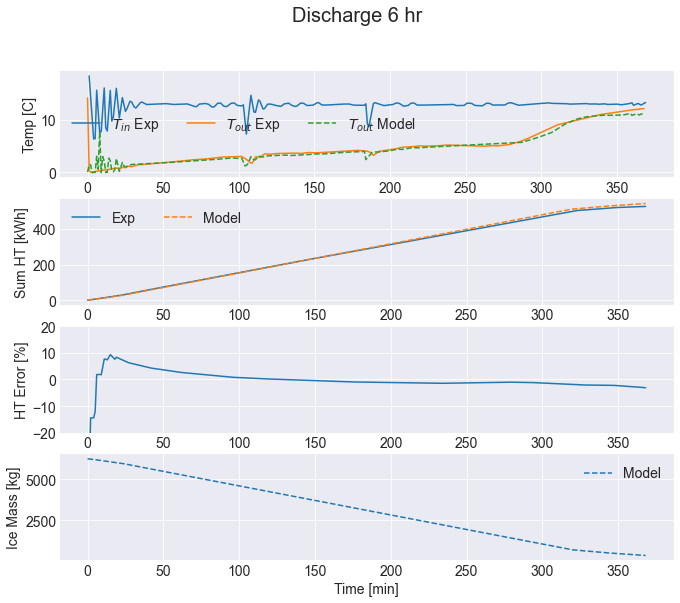

124.7171302679347 11.171237714237936


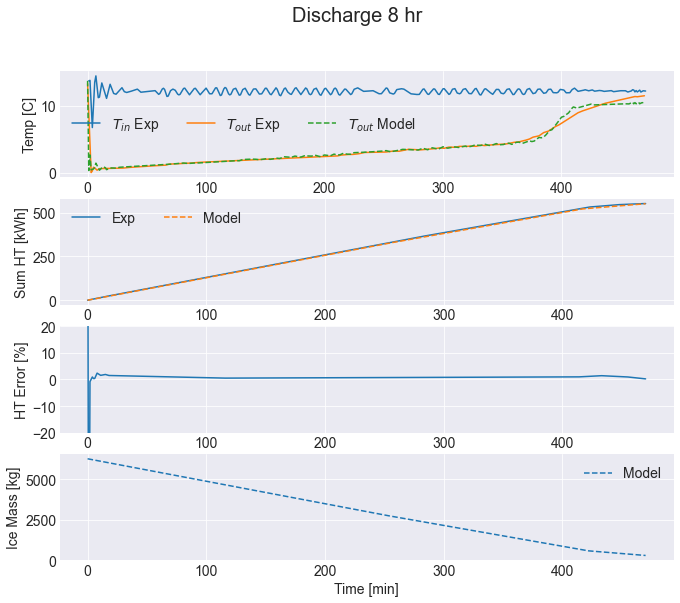

65.49573476842238 5.9355061116231544
[75.48590646786229, 80.06362641598032, 124.7171302679347, 65.49573476842238] 345.7623979201997
[5.385395333867815, 10.029461002998323, 11.171237714237936, 5.9355061116231544] 32.521600162727225


In [16]:
# With code changes
# [74.8535103506447, 82.50117157617089, 125.81838074778065, 72.47446240531208] 355.64752507990835
# [5.29527140064141, 9.962219973531237, 11.436736152504293, 7.2702369770494055] 33.96446450372635
original_total_outlet_temp_errors = []
original_total_ht_errors = []
data = {
        "tank_diameter": 89 * 0.0254,  # 89 inches
        "tank_height": 101 * 0.0254,  # 101 inches
        "fluid_volume": 1655 * 0.00378541,  # 1655 gal
        "r_value_lid": 24 / 5.67826,  # R-24
        "r_value_base": 9 / 5.67826,  # R-9
        "r_value_wall": 9 / 5.67826,  # R-9
        "initial_temperature": df_charge["T_ice_in [C]"].iloc[0],
        }
outlet_temp_errors, ht_errors = plot_exp(df_charge, data, "charge", "Charging 10 hr")
plt.plot(outlet_temp_errors, label="outlet temp errors")
plt.plot(ht_errors, label="ht errors")
plt.legend()
print(sum(outlet_temp_errors), sum(ht_errors))
original_total_outlet_temp_errors.append(sum(outlet_temp_errors))
original_total_ht_errors.append(sum(ht_errors))

data = {
        "tank_diameter": 89 * 0.0254,  # 89 inches
        "tank_height": 101 * 0.0254,  # 101 inches
        "fluid_volume": 1655 * 0.00378541,  # 1655 gal
        "r_value_lid": 24 / 5.67826,  # R-24
        "r_value_base": 9 / 5.67826,  # R-9
        "r_value_wall": 9 / 5.67826,  # R-9
        "latent_state_of_charge": 1.0,
        }

outlet_temp_errors, ht_errors = plot_exp(df_4, data, "discharge_4", "Discharge 4 hr")
original_total_outlet_temp_errors.append(sum(outlet_temp_errors))
original_total_ht_errors.append(sum(ht_errors))
print(sum(outlet_temp_errors), sum(ht_errors))

outlet_temp_errors, ht_errors = plot_exp(df_6, data, "discharge_6", "Discharge 6 hr")
original_total_outlet_temp_errors.append(sum(outlet_temp_errors))
original_total_ht_errors.append(sum(ht_errors))
print(sum(outlet_temp_errors), sum(ht_errors))

outlet_temp_errors, ht_errors = plot_exp(df_8, data, "discharge_8", "Discharge 8 hr")
original_total_outlet_temp_errors.append(sum(outlet_temp_errors))
original_total_ht_errors.append(sum(ht_errors))
print(sum(outlet_temp_errors), sum(ht_errors))

print(original_total_outlet_temp_errors, sum(original_total_outlet_temp_errors))
print(original_total_ht_errors, sum(original_total_ht_errors))

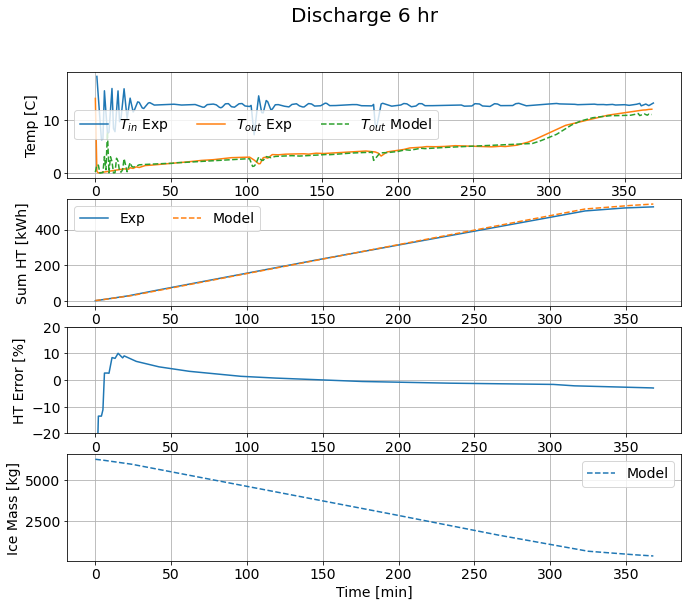

In [110]:
plot_exp(df_6, data, "discharge_6", "Discharge 6 hr")

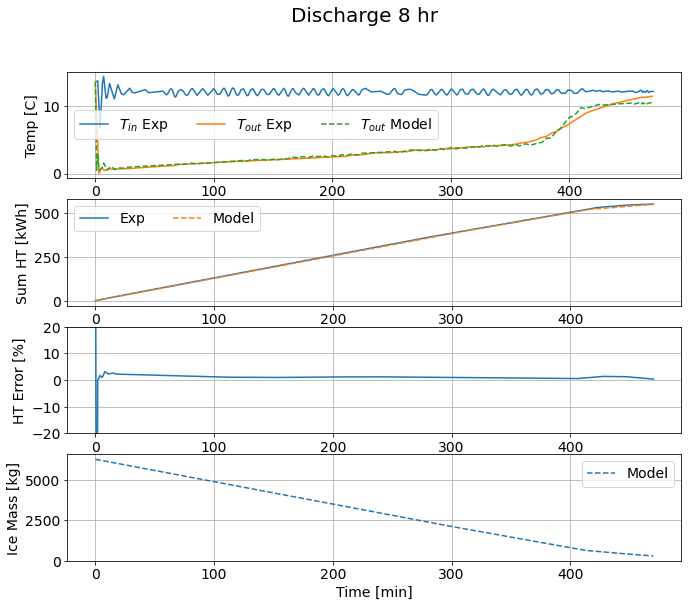

In [111]:
plot_exp(df_8, data, "discharge_8", "Discharge 8 hr")

In [66]:
def plot_charge_effectiveness():
    data = {
            "tank_diameter": 89 * 0.0254,  # 89 inches
            "tank_height": 101 * 0.0254,  # 101 inches
            "fluid_volume": 1655 * 0.00378541,  # 1655 gal
            "r_value_lid": 24 / 5.67826,  # R-24
            "r_value_base": 9 / 5.67826,  # R-9
            "r_value_wall": 9 / 5.67826,  # R-9
            "latent_state_of_charge": 1.0,
            }

    tank = IceTank(data)
    tank.tank_is_charging = True
    
    soc_range = np.linspace(0, 1, 20).tolist()
    eff_1 = []
    m_dot = 2
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_1.append(tank.effectiveness(-2.0, m_dot))
    
    eff_2 = []
    m_dot = 4
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_2.append(tank.effectiveness(-2.0, m_dot))
    
    eff_3 = []
    m_dot = 6
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_3.append(tank.effectiveness(-2.0, m_dot))
    
    fig, ax = plt.subplots(1,1)
    ax.plot(soc_range, eff_1, label="mdot= 2 kg/s", marker="x")
    ax.plot(soc_range, eff_2, label="mdot= 4 kg/s", marker="x")
    ax.plot(soc_range, eff_3, label="mdot= 6 kg/s", marker="x")
    ax.set_xlabel("SOC")
    ax.set_ylabel("Effectiveness")
    ax.set_title("Charging")
    ax.grid()
    ax.legend()
    fig.show()

/Users/mmitchel/Projects/EnergyPlus/dev/IPYNotebooks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


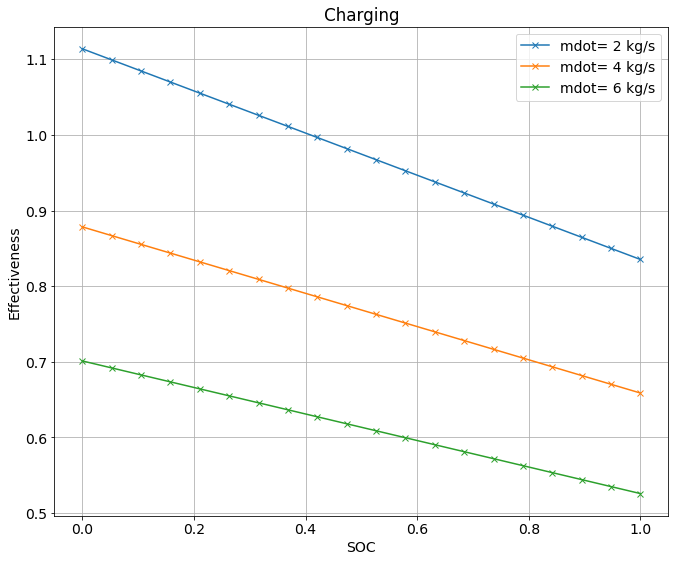

In [58]:
plot_charge_effectiveness()

In [59]:
def plot_discharge_effectiveness():
    data = {
            "tank_diameter": 89 * 0.0254,  # 89 inches
            "tank_height": 101 * 0.0254,  # 101 inches
            "fluid_volume": 1655 * 0.00378541,  # 1655 gal
            "r_value_lid": 24 / 5.67826,  # R-24
            "r_value_base": 9 / 5.67826,  # R-9
            "r_value_wall": 9 / 5.67826,  # R-9
            "latent_state_of_charge": 1.0,
            }

    tank = IceTank(data)
    tank.tank_is_charging = False
    
    soc_range = np.linspace(1, 0, 40).tolist()
    eff_1 = []
    m_dot = 2
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_1.append(tank.effectiveness(-2.0, m_dot))
    
    eff_2 = []
    m_dot = 4
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_2.append(tank.effectiveness(-2.0, m_dot))
    
    eff_3 = []
    m_dot = 6
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_3.append(tank.effectiveness(-2.0, m_dot))
    
    fig, ax = plt.subplots(1,1)
    ax.plot(soc_range, eff_1, label="mdot= 2 kg/s", marker="x")
    ax.plot(soc_range, eff_2, label="mdot= 4 kg/s", marker="x")
    ax.plot(soc_range, eff_3, label="mdot= 6 kg/s", marker="x")
    ax.set_xlabel("SOC")
    ax.set_ylabel("Effectiveness")
    ax.set_title("Discharging")
    ax.grid()
    ax.legend()
    fig.show()

/Users/mmitchel/Projects/EnergyPlus/dev/IPYNotebooks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


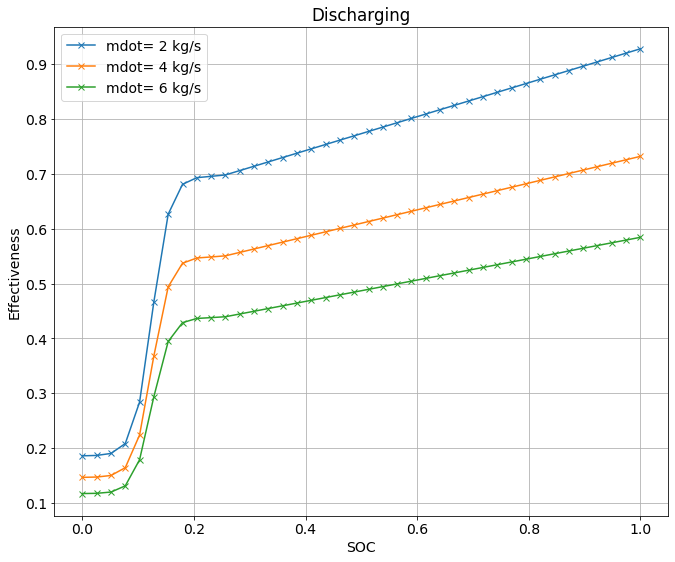

In [60]:
plot_discharge_effectiveness()